In [1]:
# Setup: Configure imports
import sys
from pathlib import Path

# Add src to path
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import matplotlib.pyplot as plt
from eigensolvers import (
    power_iteration, inverse_iteration, rayleigh_quotient_iteration,
    qr_iteration_basic, rayleigh_quotient, verify_eigenpair,
    SCIPY_AVAILABLE
)

# Plot configuration
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print(f"✓ Setup complete")
print(f"  NumPy: {np.__version__}")
print(f"  SciPy available: {SCIPY_AVAILABLE}")

✓ Setup complete
  NumPy: 2.3.5
  SciPy available: True


## 1. The Eigenvalue Problem

Given a matrix $A \in \mathbb{R}^{n \times n}$, we seek **eigenvalues** $\lambda$ and **eigenvectors** $\mathbf{v}$ such that:

$$
A\mathbf{v} = \lambda \mathbf{v}
$$

### Simple 2×2 Case

We start with the symmetric matrix:

$$
A = \begin{pmatrix} 4 & 1 \\ 1 & 3 \end{pmatrix}
$$

In [2]:
# Example 2x2 matrix
A = np.array([[4, 1], [1, 3]], dtype=float)

# Exact solution with NumPy
eigvals_exact, eigvecs_exact = np.linalg.eigh(A)

print("Matrix A:")
print(A)
print(f"\nExact eigenvalues: {eigvals_exact}")
print(f"\nExact eigenvectors:")
print(eigvecs_exact)

# Verify: A*v = λ*v
for i, lam in enumerate(eigvals_exact):
    v = eigvecs_exact[:, i]
    residual = np.linalg.norm(A @ v - lam * v)
    print(f"\nVerification λ_{i+1}: ||Av - λv|| = {residual:.2e}")

Matrix A:
[[4. 1.]
 [1. 3.]]

Exact eigenvalues: [2.38196601 4.61803399]

Exact eigenvectors:
[[ 0.52573111 -0.85065081]
 [-0.85065081 -0.52573111]]

Verification λ_1: ||Av - λv|| = 2.22e-16

Verification λ_2: ||Av - λv|| = 0.00e+00


## 2. Power Iteration: The Dominant Eigenvalue

The simplest method to find the **largest magnitude eigenvalue** (dominant).

### Algorithm

1. Initialize random vector $\mathbf{v}_0$
2. Iterate: $\mathbf{v}_{k+1} = \frac{A\mathbf{v}_k}{\|A\mathbf{v}_k\|}$
3. Eigenvalue: $\lambda = \mathbf{v}^T A \mathbf{v}$ (Rayleigh quotient)

### Convergence

$$
\text{Error} \propto \left|\frac{\lambda_2}{\lambda_1}\right|^k
$$

where $|\lambda_1| > |\lambda_2| \geq \cdots \geq |\lambda_n|$

POWER ITERATION
Dominant eigenvalue: 4.6180339886
Exact (NumPy):       4.6180339887
Absolute error:      1.17e-10
Iterations:          19

Computed eigenvector: [0.85065277 0.52572794]
Exact eigenvector:    [-0.85065081 -0.52573111]


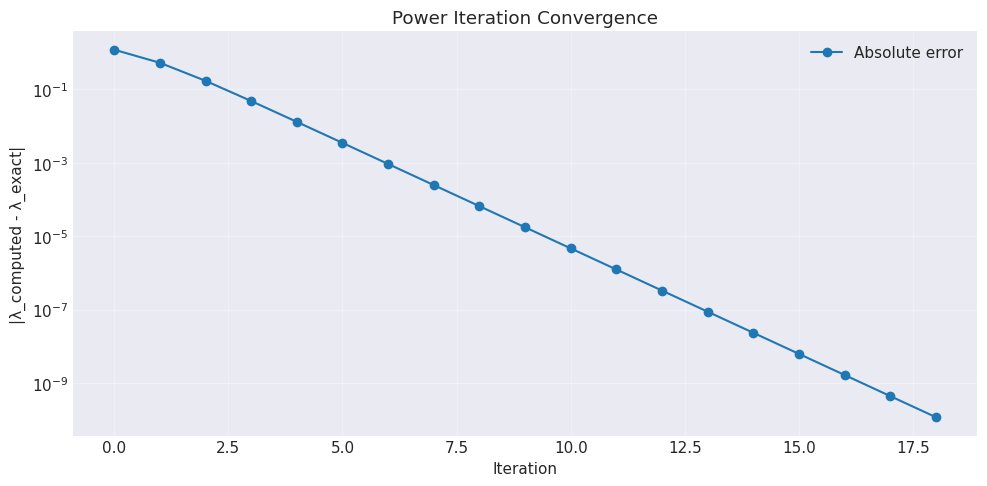


Ratio λ₂/λ₁ = 0.5158
Theoretical convergence: linear with factor ~0.5158


In [5]:
# Power iteration
lam_power, v_power, info = power_iteration(A, tol=1e-10, return_history=True)

print("=" * 50)
print("POWER ITERATION")
print("=" * 50)
print(f"Dominant eigenvalue: {lam_power:.10f}")
print(f"Exact (NumPy):       {max(eigvals_exact):.10f}")
print(f"Absolute error:      {abs(lam_power - max(eigvals_exact)):.2e}")
print(f"Iterations:          {info['iterations']}")
print(f"\nComputed eigenvector: {v_power}")
print(f"Exact eigenvector:    {eigvecs_exact[:, -1]}")

# Convergence plot
history = info.get('history', None)
if history is not None and len(history) > 0:
    # history is an array of eigenvalue estimates at each iteration
    errors = np.abs(history - max(eigvals_exact))
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(errors, 'o-', label='Absolute error')
    plt.xlabel('Iteration')
    plt.ylabel('|λ_computed - λ_exact|')
    plt.title('Power Iteration Convergence')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Verify convergence rate
    ratio = abs(eigvals_exact[0] / eigvals_exact[1])
    print(f"\nRatio λ₂/λ₁ = {ratio:.4f}")
    print(f"Theoretical convergence: linear with factor ~{ratio:.4f}")

## 3. Inverse Iteration: Interior Eigenvalues

To find the eigenvalue **closest to a shift** $\sigma$:

### Algorithm

1. Solve $(A - \sigma I)^{-1}\mathbf{v}_k$ instead of $A\mathbf{v}_k$
2. Transforms the problem: the eigenvalue closest to $\sigma$ becomes dominant

### Advantages

- Can find **any eigenvalue**, not just the dominant one
- Fast convergence if $\sigma$ is close to an eigenvalue

INVERSE ITERATION (σ = 2.5)
Eigenvalue found:  2.3819660113
Exact (NumPy):     2.3819660113
Absolute error:    5.52e-13
Iterations:        5

--- With σ = 4.8 ---
Eigenvalue found:  4.6180339887
Exact (NumPy):     4.6180339887
Iterations:        6


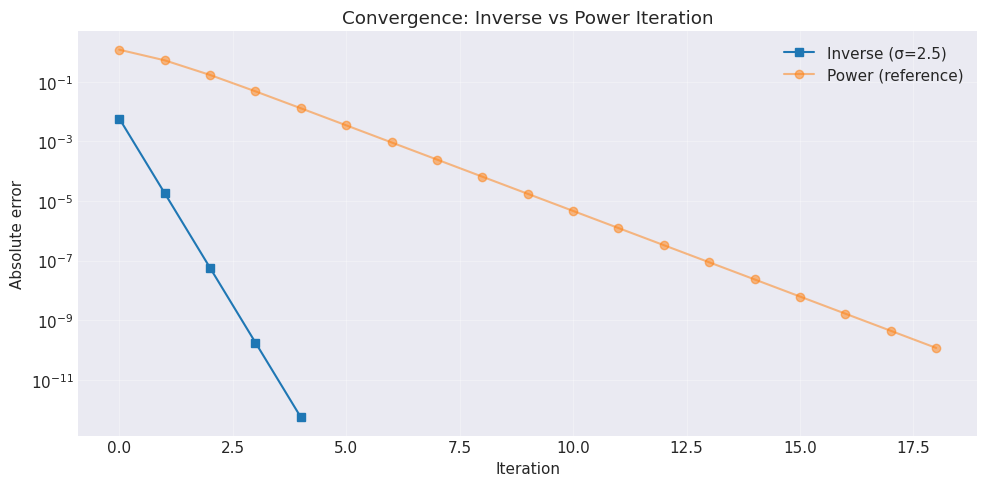

In [7]:
# Inverse iteration with shift near the smallest eigenvalue
sigma = 2.5
lam_inv, v_inv, info_inv = inverse_iteration(A, sigma=sigma, tol=1e-10, return_history=True)

print("=" * 50)
print(f"INVERSE ITERATION (σ = {sigma})")
print("=" * 50)
print(f"Eigenvalue found:  {lam_inv:.10f}")
print(f"Exact (NumPy):     {min(eigvals_exact):.10f}")
print(f"Absolute error:    {abs(lam_inv - min(eigvals_exact)):.2e}")
print(f"Iterations:        {info_inv['iterations']}")

# Compare with different shift (near the large eigenvalue)
sigma2 = 4.8
lam_inv2, v_inv2, info_inv2 = inverse_iteration(A, sigma=sigma2, tol=1e-10)

print(f"\n--- With σ = {sigma2} ---")
print(f"Eigenvalue found:  {lam_inv2:.10f}")
print(f"Exact (NumPy):     {max(eigvals_exact):.10f}")
print(f"Iterations:        {info_inv2['iterations']}")

# Visualize shift effect
history_inv = info_inv.get('history', None)
if history_inv is not None and len(history_inv) > 0:
    # history is an array of eigenvalue estimates
    errors_inv = np.abs(history_inv - min(eigvals_exact))
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(errors_inv, 's-', label=f'Inverse (σ={sigma})')
    if history is not None and len(history) > 0:
        plt.semilogy(errors, 'o-', alpha=0.5, label='Power (reference)')
    plt.xlabel('Iteration')
    plt.ylabel('Absolute error')
    plt.title('Convergence: Inverse vs Power Iteration')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Rayleigh Quotient Iteration: Cubic Convergence

Combines inverse iteration with **adaptive shift**:

$$
\sigma_k = \mathbf{v}_k^T A \mathbf{v}_k \quad \text{(Rayleigh quotient)}
$$

### Convergence

$$
\text{Error}_{k+1} \propto (\text{Error}_k)^3
$$

**Cubic!** Much faster than power/inverse (linear).

RAYLEIGH QUOTIENT ITERATION (σ₀ = 4.5)
Eigenvalue found:  4.6180339887
Exact (NumPy):     4.6180339887
Absolute error:    0.00e+00
Iterations:        3 ← Very few!


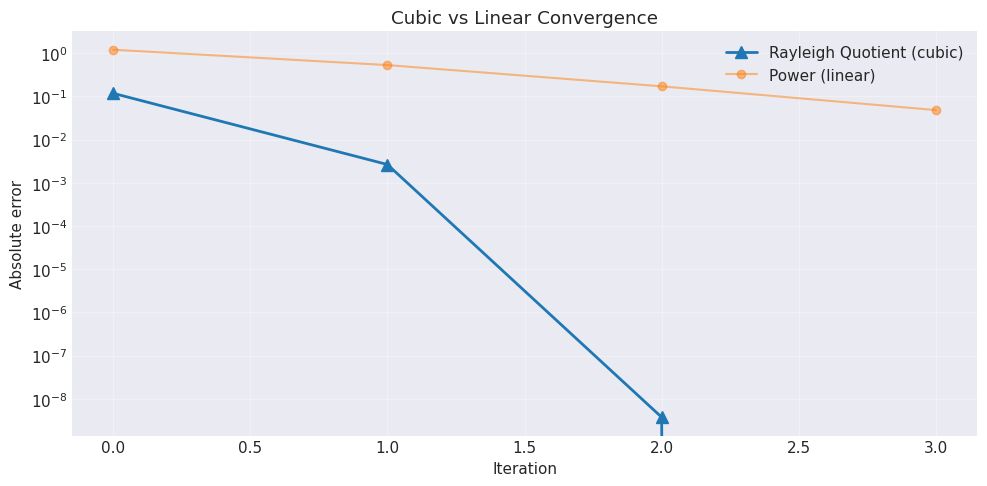


Note the much steeper slope for Rayleigh!


In [9]:
# Rayleigh quotient iteration
v0 = np.array([1, 0], dtype=float)
sigma0 = 4.5  # Near the large eigenvalue

lam_rq, v_rq, info_rq = rayleigh_quotient_iteration(
    A, v0=v0, sigma0=sigma0, tol=1e-10, return_history=True
)

print("=" * 50)
print(f"RAYLEIGH QUOTIENT ITERATION (σ₀ = {sigma0})")
print("=" * 50)
print(f"Eigenvalue found:  {lam_rq:.10f}")
print(f"Exact (NumPy):     {max(eigvals_exact):.10f}")
print(f"Absolute error:    {abs(lam_rq - max(eigvals_exact)):.2e}")
print(f"Iterations:        {info_rq['iterations']} ← Very few!")

# Convergence comparison
history_rq = info_rq.get('history', None)
if history_rq is not None and len(history_rq) > 0:
    # history is an array of eigenvalue estimates
    errors_rq = np.abs(history_rq - max(eigvals_exact))
    
    plt.figure(figsize=(10, 5))
    plt.semilogy(errors_rq, '^-', linewidth=2, markersize=8, label='Rayleigh Quotient (cubic)')
    if history is not None and len(history) > 0:
        plt.semilogy(errors[:len(errors_rq)], 'o-', alpha=0.5, label='Power (linear)')
    plt.xlabel('Iteration')
    plt.ylabel('Absolute error')
    plt.title('Cubic vs Linear Convergence')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\nNote the much steeper slope for Rayleigh!")

## 5. QR Iteration: All Eigenvalues at Once

The previous methods find **one eigenvalue** at a time. QR iteration finds **all simultaneously**.

### Algorithm

1. Initialize $A_0 = A$
2. Iterate:
   - QR factorization: $A_k = Q_k R_k$
   - Multiply in reverse: $A_{k+1} = R_k Q_k$
3. $A_k \to$ diagonal with eigenvalues on the diagonal

### Key Property

$$
A_{k+1} = R_k Q_k = Q_k^T A_k Q_k \quad \text{(similarity transformation)}
$$

Same eigenvalues, but matrix converges to diagonal form.

QR ITERATION (3×3 matrix)
Matrix A:
[[4. 1. 0.]
 [1. 3. 1.]
 [0. 1. 2.]]

Eigenvalues found:  [1.26794919 3.         4.73205081]
Exact eigenvalues:  [1.26794919 3.         4.73205081]
Maximum error:      4.44e-15
Iterations:         48


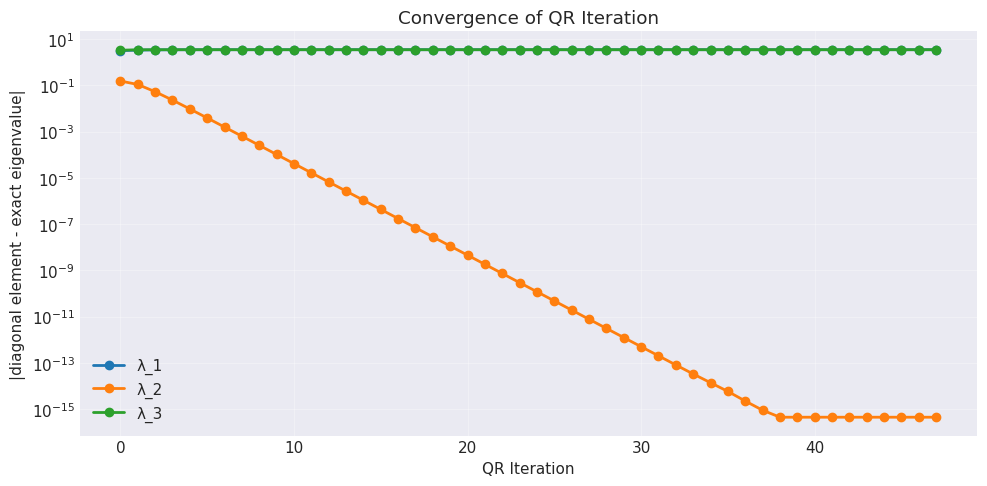


Diagonal evolution (first 5 iterations):
Iteration 0: [4.41176471 3.15345269 1.43478261]
Iteration 1: [4.59292035 3.10876032 1.29831933]
Iteration 2: [4.67372354 3.05296089 1.27331557]
Iteration 3: [4.70815597 3.02294363 1.2689004 ]
Iteration 4: [4.72236918 3.00951234 1.26811848]

Final diagonal (iteration 47): [4.73205081 3.         1.26794919]
Exact eigenvalues: [1.26794919 3.         4.73205081]


In [11]:
# QR iteration on 3x3 matrix
A3 = np.array([[4, 1, 0], [1, 3, 1], [0, 1, 2]], dtype=float)

eigvals_qr, Q_qr, info_qr = qr_iteration_basic(A3, tol=1e-10, return_history=True)
eigvals_exact3 = np.linalg.eigvalsh(A3)

print("=" * 50)
print("QR ITERATION (3×3 matrix)")
print("=" * 50)
print("Matrix A:")
print(A3)
print(f"\nEigenvalues found:  {np.sort(eigvals_qr)}")
print(f"Exact eigenvalues:  {np.sort(eigvals_exact3)}")
print(f"Maximum error:      {np.max(np.abs(np.sort(eigvals_qr) - np.sort(eigvals_exact3))):.2e}")
print(f"Iterations:         {info_qr['iterations']}")

# Visualize convergence of diagonal elements to eigenvalues
history_qr = info_qr.get('history', None)
if history_qr is not None and len(history_qr) > 0:
    # history is array of diagonals at each iteration (shape: iterations x n)
    n = history_qr.shape[1]
    
    plt.figure(figsize=(10, 5))
    for i in range(n):
        errors = np.abs(history_qr[:, i] - eigvals_exact3[i])
        # Avoid log of zero by setting minimum
        errors = np.maximum(errors, 1e-16)
        plt.semilogy(errors, 'o-', linewidth=2, label=f'λ_{i+1}')
    
    plt.xlabel('QR Iteration')
    plt.ylabel('|diagonal element - exact eigenvalue|')
    plt.title('Convergence of QR Iteration')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Show evolution of diagonal
    print("\nDiagonal evolution (first 5 iterations):")
    for i, diag in enumerate(history_qr[:5]):
        print(f"Iteration {i}: {diag}")
    
    print(f"\nFinal diagonal (iteration {len(history_qr)-1}): {history_qr[-1]}")
    print(f"Exact eigenvalues: {eigvals_exact3}")

## 6. Method Comparison

### 10×10 Test Matrix

In [12]:
# Random symmetric 10x10 matrix
np.random.seed(42)
n = 10
B = np.random.randn(n, n)
A10 = B @ B.T  # Symmetric positive definite

eigvals_exact10 = np.linalg.eigvalsh(A10)

print("10×10 symmetric positive definite matrix")
print(f"Exact eigenvalues: {np.sort(eigvals_exact10)}")
print(f"Condition number: {eigvals_exact10[-1]/eigvals_exact10[0]:.2e}")

10×10 symmetric positive definite matrix
Exact eigenvalues: [ 0.05084459  0.47175976  0.76986062  2.2766332   4.0234359   4.67167082
  9.18168326 16.41715354 18.04844348 26.81914421]
Condition number: 5.27e+02


/workspaces/Computational-Physics-Numerical-methods/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=8.42986e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



METHOD COMPARISON (10×10 Matrix)
Method          Iterations      Time (ms)       Error          
----------------------------------------------------------------------
Power           31              0.867           1.65e-09       
Inverse         7               0.531           4.33e-14       
Rayleigh        6               2.916           1.04e+01       
QR              202             21.168          8.17e-14       


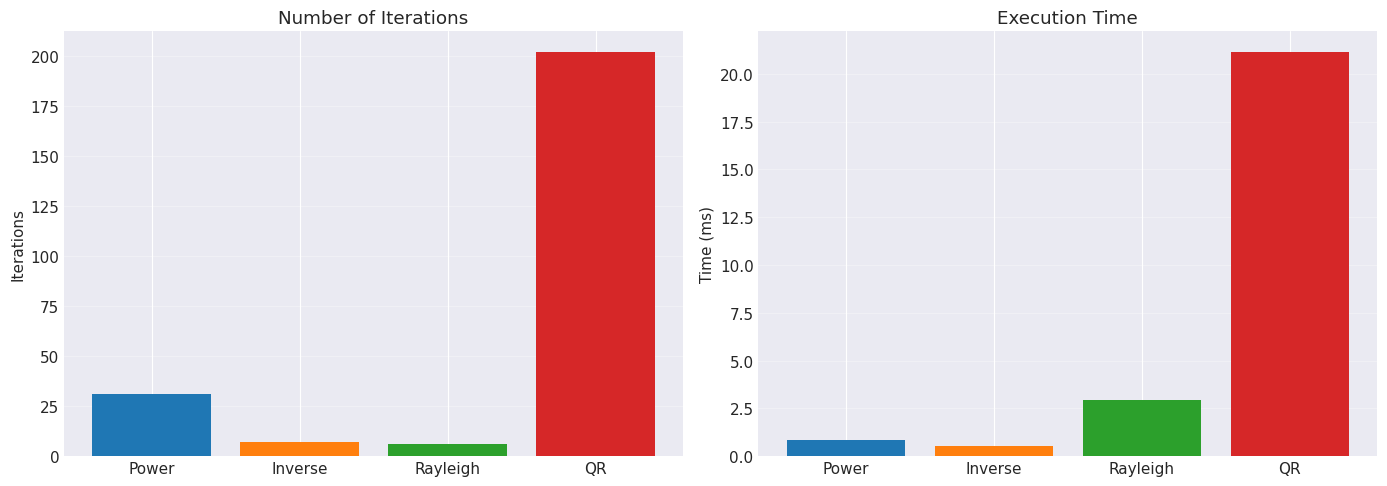

In [13]:
# Method benchmark
import time

results = {}

# Power iteration
t0 = time.time()
lam_p, v_p, info_p = power_iteration(A10, tol=1e-10)
t_power = time.time() - t0
results['Power'] = {
    'iterations': info_p['iterations'],
    'time': t_power,
    'error': abs(lam_p - max(eigvals_exact10))
}

# Inverse iteration (smallest eigenvalue)
t0 = time.time()
lam_i, v_i, info_i = inverse_iteration(A10, sigma=0.1, tol=1e-10)
t_inv = time.time() - t0
results['Inverse'] = {
    'iterations': info_i['iterations'],
    'time': t_inv,
    'error': abs(lam_i - min(eigvals_exact10))
}

# Rayleigh quotient
t0 = time.time()
lam_r, v_r, info_r = rayleigh_quotient_iteration(A10, sigma0=max(eigvals_exact10)*0.9, tol=1e-10)
t_rq = time.time() - t0
results['Rayleigh'] = {
    'iterations': info_r['iterations'],
    'time': t_rq,
    'error': abs(lam_r - max(eigvals_exact10))
}

# QR iteration
t0 = time.time()
eigvals_q, Q_q, info_q = qr_iteration_basic(A10, tol=1e-10)
t_qr = time.time() - t0
results['QR'] = {
    'iterations': info_q['iterations'],
    'time': t_qr,
    'error': np.max(np.abs(np.sort(eigvals_q) - np.sort(eigvals_exact10)))
}

# Results table
print("\n" + "=" * 70)
print("METHOD COMPARISON (10×10 Matrix)")
print("=" * 70)
print(f"{'Method':<15} {'Iterations':<15} {'Time (ms)':<15} {'Error':<15}")
print("-" * 70)
for name, res in results.items():
    print(f"{name:<15} {res['iterations']:<15} {res['time']*1000:<15.3f} {res['error']:<15.2e}")

# Comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

names = list(results.keys())
iters = [results[n]['iterations'] for n in names]
times = [results[n]['time']*1000 for n in names]

axes[0].bar(names, iters, color=['C0', 'C1', 'C2', 'C3'])
axes[0].set_ylabel('Iterations')
axes[0].set_title('Number of Iterations')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(names, times, color=['C0', 'C1', 'C2', 'C3'])
axes[1].set_ylabel('Time (ms)')
axes[1].set_title('Execution Time')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Recommended Use Cases

| Method | When to Use | Advantages | Disadvantages |
|--------|-------------|----------|-------------|
| **Power Iteration** | Only dominant eigenvalue | Simple, robust | Only λ_max, slow convergence |
| **Inverse Iteration** | Eigenvalue near σ | Finds any λ | Requires solving linear system |
| **Rayleigh Quotient** | Fast convergence | Cubic! | Sensitive to singularities |
| **QR Iteration** | All eigenvalues | Finds all | Expensive (O(n³) per iteration) |

### Practical Recommendations

1. **Large sparse matrices** → Use Krylov methods (Lanczos/Arnoldi) [next notebook]
2. **Only a few eigenvalues** → Inverse/Rayleigh with shifts
3. **Small dense matrices** → QR iteration or NumPy/SciPy
4. **Physics problems (Schrödinger)** → Specialized methods for specific structure

## 8. Application: Normal Modes of a Mass-Spring System

System of 3 masses connected by springs:

```
   k₁      k₂      k₃      k₄
├──┴──m₁──┴──m₂──┴──m₃──┴──┤
```

Equation of motion:

$$
M\ddot{\mathbf{x}} + K\mathbf{x} = 0
$$

Eigenvalues of $M^{-1}K$ give frequencies: $\omega_i^2 = \lambda_i$

In [14]:
# Mass-spring system
m = np.array([1.0, 1.0, 1.0])  # masses
k = np.array([1.0, 1.0, 1.0, 1.0])  # spring constants

# Stiffness matrix K
K = np.array([
    [k[0] + k[1], -k[1], 0],
    [-k[1], k[1] + k[2], -k[2]],
    [0, -k[2], k[2] + k[3]]
])

# Mass matrix M
M = np.diag(m)
M_inv = np.diag(1/m)

# Eigenvalue problem: M^(-1)K
A_spring = M_inv @ K

print("Matrix M^(-1)K:")
print(A_spring)

# Find normal modes with QR
omega_sq, modes, info = qr_iteration_basic(A_spring, tol=1e-10)
omega_sq_sorted = np.sort(omega_sq)
omega = np.sqrt(omega_sq_sorted)

print("\n" + "=" * 50)
print("NORMAL MODES")
print("=" * 50)
print(f"Frequencies ω (rad/s): {omega}")
print(f"Periods T (s):         {2*np.pi/omega}")

# Verify with NumPy
omega_sq_exact = np.linalg.eigvalsh(A_spring)
omega_exact = np.sqrt(np.sort(omega_sq_exact))
print(f"\nExact ω (NumPy):       {omega_exact}")
print(f"Maximum error:         {np.max(np.abs(omega - omega_exact)):.2e}")

Matrix M^(-1)K:
[[ 2. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  2.]]

NORMAL MODES
Frequencies ω (rad/s): [0.76536686 1.41421356 1.84775907]
Periods T (s):         [8.20937722 4.44288294 3.40043538]

Exact ω (NumPy):       [0.76536686 1.41421356 1.84775907]
Maximum error:         4.44e-16


## Summary and Next Steps

### What We Learned

✅ **Power Iteration**: dominant eigenvalue, linear convergence  
✅ **Inverse Iteration**: any eigenvalue with shift σ  
✅ **Rayleigh Quotient**: cubic convergence, very efficient  
✅ **QR Iteration**: all eigenvalues simultaneously  

### Next Notebook: `02_lanczos_method.ipynb`

- Lanczos method for **large sparse** matrices
- Reduction to tridiagonal form
- Application to 1D Schrödinger equation

### References

1. Trefethen & Bau, *Numerical Linear Algebra* (1997)
2. Golub & Van Loan, *Matrix Computations* (4th ed.)
3. Saad, *Numerical Methods for Large Eigenvalue Problems* (2011)